# The Machine Learning Workflow Annotated

Source: [Pytorch / Learn the Basics](https://pytorch.org/tutorials/beginner/basics/intro.html)

```{attention} TODO
- Store a properly parametrized model in the repo and USE it (inference) before creating your own.
- Simplify model archi, get rid of sequential
- Explain logit stuff & give math formulas
- Show that the neural network accepts batched data
- Plot ReLU graph
- Annotate & tweak learning
```

In [56]:
import torch
import torchvision

## The FashionMNIST Dataset 

In [57]:
# Download training data from open datasets.
training_data = torchvision.datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor(),
)

# Download test data from open datasets.
test_data = torchvision.datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor(),
)

In [58]:
data = torchvision.datasets.FashionMNIST(root="data") # by default: training data set, no input/output transform, no download
data

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train

In [59]:
# data is list-like ; each item in an input-output pair
datum = data[0]
datum

(<PIL.Image.Image image mode=L size=28x28>, 9)

In [60]:
image, index = datum

In [61]:
image

In [62]:
# The output is a number that denotes the class of the pictured object. The list of categories is:
print(data.classes)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [63]:
# Get the category name from the index:
data.classes[index] # that checks out!

'Ankle boot'

In [64]:
import pandas as pd
df = [{"image": image, "category": data.classes[index]} for image, index in data]
df = pd.DataFrame(df)
df

,image,category
0,<PIL.Image.Image image mode=L size=28x28 at 0x...,Ankle boot
1,<PIL.Image.Image image mode=L size=28x28 at 0x...,T-shirt/top
2,<PIL.Image.Image image mode=L size=28x28 at 0x...,T-shirt/top
3,<PIL.Image.Image image mode=L size=28x28 at 0x...,Dress
4,<PIL.Image.Image image mode=L size=28x28 at 0x...,T-shirt/top
...,...,...
59995,<PIL.Image.Image image mode=L size=28x28 at 0x...,Sandal
59996,<PIL.Image.Image image mode=L size=28x28 at 0x...,Trouser
59997,<PIL.Image.Image image mode=L size=28x28 at 0x...,Dress
59998,<PIL.Image.Image image mode=L size=28x28 at 0x...,T-shirt/top


In [65]:
import base64
import io
from IPython.display import HTML

def image_formatter(image):
    with io.BytesIO() as buffer:
        image.save(buffer, "jpeg")
        _bytes = buffer.getvalue()
    _base64 = base64.b64encode(_bytes).decode("ascii")
    return f'<img src="data:image/jpeg;base64, {_base64}">'

HTML(df.head().to_html(formatters={'image': image_formatter}, escape=False))

,image,category
0,"<img src=""data:image/jpeg;base64, /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/wAALCAAcABwBAREA/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/9oACAEBAAA/APn+tbw1oNx4m8QWmkWx2yXD4LkZCADJJ+gFbviL4a63oc7COE3MW4hdn38duD976jNc9daDqllIsc9lKrMu4YGeMkdR7gj8KzcV7H8BtEvV16+1iWCeG1Wz8mOV02pIzupwCeuAp6Z98cZ90aIzLIlw0c0ZJ4KgjHoeOa+evjS9n/wnMcNxBPCYLKONFhA2FNzMpGenDcgd816V4K03wefC+m3NlpVhP+5QSXBiR5fMx825iMg5zwce3FdbOzTwgW90lu6uCm8eYrL02soIyCPQgggEdMGQ3cluiPNK0rJwrRQBNueuMkt+teNfGKxsdY8WWdxNqcNo66eieXMwVsb5DnH415Hp2rajpE5n02/urOUjBe3laMkehIPIrVm8eeLrhNknibVivoLtx/I1UPinxC3XXtUP1vJP8ay5JZJpGkldnduSzHJP41//2Q=="">",Ankle boot
1,"<img src=""data:image/jpeg;base64, /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/wAALCAAcABwBAREA/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/9oACAEBAAA/AOB+E3gyz8V6xez6lE01jYRqWiDFQ8jk7QSOcYVjxjoK9hlufDultLpcPhSa5itZdjra6NFNCshiEh5Yj5tmCTTjpvhnxg9zYX/huSCe3SMyLeWC20yI+7aUZTnb8jcA446V81a7pcmh69qGlytue0uHh3f3gpIB/Ec/jXSeBfiJf+CvMt7ezsp7a4lV5vORg/HHDKR2z1z1NfQF94U8Oapez3l7o9vczzkGSSR5MvjAGcMB0C9B2rC8Uz2Xw28LXGp+HdIsoJ5JIoCr+YyNyx5y2eMtjBHJr5517WrrxFrdzq16sS3FwwLiJdqjAAGB9AKzq+zkXjAAGcnivP8A4zLu8ATf7N1C/wCrD+tfONFfUf8AwlV5AmBbWrbQACwf0Ho1cV8S/Edzqfg66t5be2RTLFzGHzw2e7GvEa//2Q=="">",T-shirt/top
2,"<img src=""data:image/jpeg;base64, /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/wAALCAAcABwBAREA/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/9oACAEBAAA/APn+vX/DGqaVa6HZw6r4X07VQIFMLyxqrpkZIJ2/MM5P4nrXH+PZUuLu0njs7a0VlcLDbRBERQRhRgc49fc1yFFenaeANMsx6QRj/wAdFc/41H7uwOOcyc+3yf8A165GivUbVSlnAh6rEgP/AHyKwPGa7rK0fH3JGHX1A/wrjaK6zRPEN5Ni2mWKQImA7Kdxx6kGsfWdXudSmEc2xY4idqRjAz6nPJNZdf/Z"">",T-shirt/top
3,"<img src=""data:image/jpeg;base64, /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/wAALCAAcABwBAREA/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/9oACAEBAAA/APHfBp0z/hKLRdWSNrd22KZseWrnhS4PG3PXPHc8A17c95bWoiiawsW8n/VK9oj+Uf8AZ4+X8K434kXmnXOjGe9t4n1CZgttKiBZMjqS2MlQD0Oeo6da8lor3OZzeQWsqFGZ7dCwEijB2D34rg/iIXM2nbiCPLfowIByCeh9MVxFaGh2iX+uWVtIu6N5V3r6qOSPyBr1eS1iklWZoIWdoppM+WOQFBB6fWs7xzpUUnhiSWKFFNrLn5VA29PTsVZPyFeU1c0vUZdJ1GK9gSN5It20SAleVI7EetdHJ441P7NbuILMGOLygAjYKkMv970qvqPjrVdTsLi0mitEW4wJHjjIY4VV9cdFHauYr//Z"">",Dress
4,"<img src=""data:image/jpeg;base64, /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/wAALCAAcABwBAREA/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/9oACAEBAAA/APn+vp6f4feFNcg0LUIfDdlsleJrrypGgAt2iZtwVGUFg5TsSRn8PJ/jTYWGm+NbeDTrK2tIfsEbGO2iWNSxZ+cDv

In [66]:
# Torch only want to deal with numeric array called "tensors", not images.
# So, it is perfectly happy with the output as a numeric value, but we need to transform the input
image_to_tensor = torchvision.transforms.ToTensor()
t = image_to_tensor(image)
t

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
          0.2863, 0.0000, 0.0000, 0.0039, 0.0157, 0.0000,

In [67]:
t.shape, t.dtype

(torch.Size([1, 28, 28]), torch.float32)

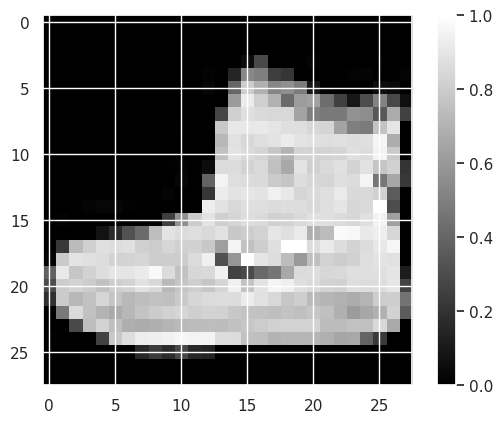

In [68]:
# No information has been lost in the conversion process!
import matplotlib.pyplot as plt
plt.imshow(t.squeeze(), cmap="grey")
plt.colorbar()
None

## Neural Network Model

In [69]:
class NeuralNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = torch.nn.Flatten()
        self.linear_relu_stack = torch.nn.Sequential(
            torch.nn.Linear(28*28, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [70]:
model = NeuralNetwork()
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [71]:
# Load the reference (trained) model for this architecture
model.load_state_dict(torch.load("models/reference-model.pth"))

<All keys matched successfully>

In [72]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.0342,  0.0248,  0.0117,  ..., -0.0111, -0.0175,  0.0079],
         [-0.0092, -0.0311, -0.0346,  ..., -0.0293, -0.0238, -0.0279],
         [-0.0290, -0.0065, -0.0276,  ...,  0.0121,  0.0193,  0.0302],
         ...,
         [-0.0351,  0.0179, -0.0232,  ...,  0.0179,  0.0348,  0.0175],
         [ 0.0262,  0.0299, -0.0006,  ...,  0.0071,  0.0305,  0.0346],
         [ 0.0205,  0.0105, -0.0038,  ..., -0.0338, -0.0255, -0.0052]],
        requires_grad=True),
 Parameter containing:
 tensor([-1.4645e-02,  1.0684e-02, -5.3957e-02,  9.1686e-02, -9.7592e-03,
          7.5287e-03,  4.9035e-02,  2.9113e-02,  6.6093e-03,  5.6122e-02,
          3.1363e-02, -2.9396e-02, -3.0968e-02, -2.7735e-03,  3.0156e-02,
         -3.5608e-03,  7.0412e-02,  5.2068e-02, -1.7248e-02,  4.3304e-03,
          9.0768e-03,  2.8084e-02,  7.2679e-02,  1.1108e-02, -8.1378e-03,
          9.3388e-03,  9.6413e-02,  3.7593e-02, -4.2288e-03, -6.8505e-03,
         -2.3459e-02,  7.2790e-02,  4.93

In [75]:
with torch.no_grad():
    to_tensor = torchvision.transforms.ToTensor()
    input = to_tensor(image)
    output = model(input)
output

tensor([[-5.4033, -7.8839, -5.0445, -4.8852, -6.4610,  7.9506, -3.8397,  8.9924,
          4.9355, 14.2599]])

In [76]:
logits = output.data.squeeze()
probas = torch.nn.functional.softmax(logits, dim=-1)
probas

tensor([2.8662e-09, 2.3988e-10, 4.1035e-09, 4.8118e-09, 9.9534e-10, 1.8066e-03,
        1.3689e-08, 5.1202e-03, 8.8592e-05, 9.9298e-01])

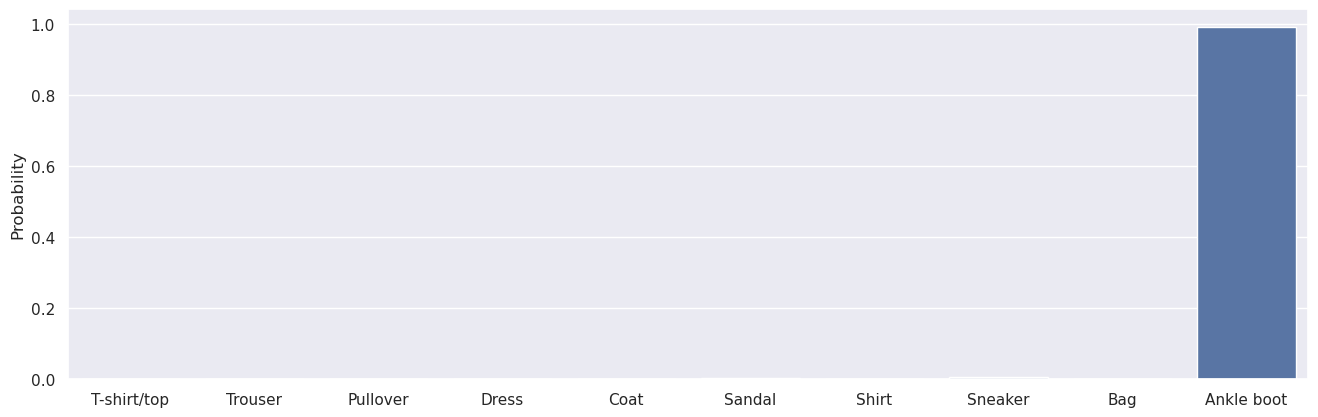

In [77]:
import seaborn as sns; sns.set_theme()
data = {training_data.classes[i]: p.item() for i, p in enumerate(probas)}
sns.barplot(data)
plt.gcf().set_figwidth(16)
plt.gca().set_ylabel("Probability")
None

In [78]:
index = probas.argmax().item()
index

9

In [80]:
training_data.classes[index] # The choice of the model

'Ankle boot'

In [91]:
def prediction(image, sort=True):
    to_tensor = torchvision.transforms.ToTensor()
    model.eval()
    with torch.no_grad():
        input = to_tensor(image)
        output = model(input)
    logits = output.data.squeeze()
    probas = torch.nn.functional.softmax(logits, dim=-1)
    category_proba = [(training_data.classes[i], p.item()) for i, p in enumerate(probas)]
    if sort:
        category_proba = sorted(category_proba, key=lambda pair: -pair[1])
    return dict(category_proba)

In [92]:
prediction(image)

{'Ankle boot': 0.9929846525192261,
 'Sneaker': 0.005120150279253721,
 'Sandal': 0.0018065760377794504,
 'Bag': 8.859220542944968e-05,
 'Shirt': 1.368937763146505e-08,
 'Dress': 4.8117980711026576e-09,
 'Pullover': 4.103489548157313e-09,
 'T-shirt/top': 2.8661895079551414e-09,
 'Coat': 9.953390334160872e-10,
 'Trouser': 2.398767018352288e-10}

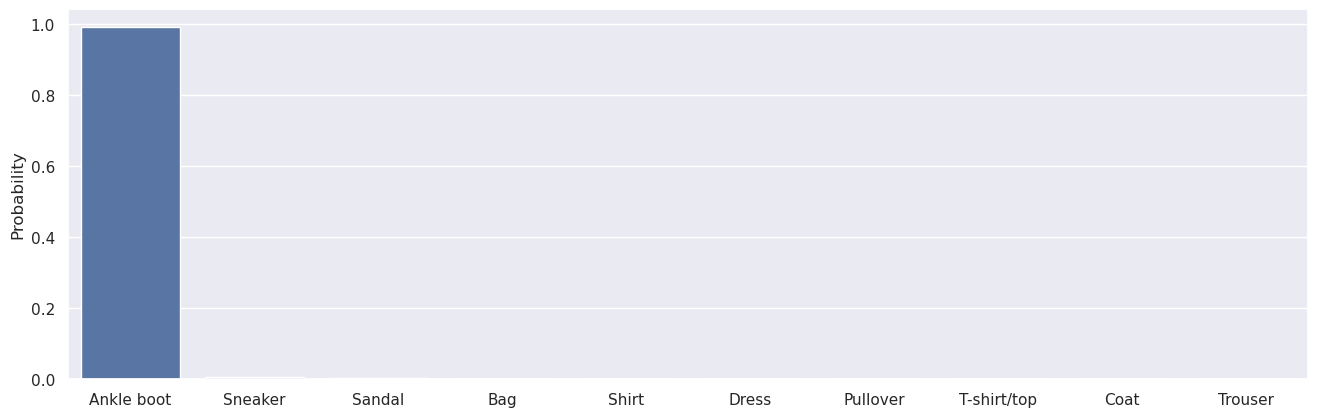

In [94]:
sns.barplot(prediction(image))
plt.gcf().set_figwidth(16)
plt.gca().set_ylabel("Probability")
None

### Under the Hood

In [22]:
model.flatten

Flatten(start_dim=1, end_dim=-1)

In [23]:
image

In [24]:
t = torchvision.transforms.ToTensor()(image)
t

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
          0.2863, 0.0000, 0.0000, 0.0039, 0.0157, 0.0000,

In [25]:
model.flatten(t)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000,
         0.0510, 0.2863, 0.0000, 0.0000, 0.0039, 0.0157, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0039, 0.0

In [26]:
model.linear_relu_stack

Sequential(
  (0): Linear(in_features=784, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=512, bias=True)
  (3): ReLU()
  (4): Linear(in_features=512, out_features=10, bias=True)
)

In [27]:
L1 = model.linear_relu_stack[0]
L1

Linear(in_features=784, out_features=512, bias=True)

In [28]:
L1.in_features == 28 * 28

True

In [29]:
L1_params = {name: param.data for name, param in L1.named_parameters()}
print(L1_params)

{'weight': tensor([[-0.0342,  0.0248,  0.0117,  ..., -0.0111, -0.0176,  0.0079],
        [-0.0092, -0.0311, -0.0345,  ..., -0.0288, -0.0236, -0.0279],
        [-0.0290, -0.0065, -0.0275,  ...,  0.0129,  0.0196,  0.0302],
        ...,
        [-0.0351,  0.0179, -0.0232,  ...,  0.0172,  0.0345,  0.0175],
        [ 0.0262,  0.0299, -0.0006,  ...,  0.0054,  0.0298,  0.0345],
        [ 0.0205,  0.0105, -0.0038,  ..., -0.0341, -0.0256, -0.0052]]), 'bias': tensor([-8.2855e-03,  5.9922e-03, -1.4251e-02,  1.7182e-02, -4.3371e-03,
         1.0525e-03,  1.8375e-02,  3.5357e-03,  9.4783e-03,  9.2447e-03,
         1.7753e-03, -3.3951e-02, -3.3198e-02, -2.2237e-02,  2.8606e-02,
         7.3972e-03,  2.8100e-02,  3.0192e-02, -6.8621e-03,  9.4763e-03,
        -2.1431e-02,  1.3905e-02,  3.0052e-02, -3.3919e-02,  8.1713e-04,
        -2.1485e-02,  3.5264e-02, -3.5414e-03, -1.3448e-02, -3.3623e-02,
         1.6981e-03,  2.0920e-02,  3.3235e-02, -1.9847e-02, -2.3705e-02,
         3.0954e-02,  3.2013e-02, -

In [30]:
b1 = L1_params["bias"]
b1.shape

torch.Size([512])

In [31]:
A1 = L1_params["weight"]
A1.shape

torch.Size([512, 784])

In [32]:
to_tensor = torchvision.transforms.ToTensor() 
t = to_tensor(image)
print(t.shape)
tf = torch.flatten(t)
print(tf.shape)
x1 = A1 @ tf + b1
x1

torch.Size([1, 28, 28])
torch.Size([784])


tensor([ 3.3492e-02,  6.1633e-02,  5.1995e-01,  1.1839e-01, -3.1613e-01,
        -4.5411e-01,  1.9399e-01,  6.0684e-01,  4.4959e-01, -2.0643e-01,
         7.5134e-01, -8.9815e-02, -7.5977e-02,  3.5863e-01, -2.4482e-01,
         2.1364e-01,  1.1519e-01,  2.4052e-01,  9.1226e-01,  1.2893e-01,
         8.9580e-02,  3.4758e-01, -1.5707e-01,  2.4506e-01, -3.7254e-01,
        -6.1034e-01,  3.4003e-01,  1.6744e-01,  7.3205e-01, -2.3025e-01,
         2.3862e-01,  3.8583e-01, -4.8708e-01,  1.3534e-01,  2.7375e-01,
        -8.0974e-02, -2.9969e-01,  2.7948e-01, -6.0435e-02,  3.1560e-01,
        -1.6601e-01, -1.1265e-01,  2.0642e-01,  4.3809e-01, -3.1835e-01,
         2.4772e-01,  2.6525e-01,  1.3336e-01,  6.0694e-01,  4.2704e-01,
         6.5305e-02, -5.2409e-01, -8.8076e-03, -2.6131e-01,  1.3206e-01,
        -1.6638e-01,  2.8863e-02, -7.4440e-01, -9.6469e-01, -1.0273e-01,
        -2.6128e-01, -8.5045e-02,  2.6499e-01,  3.4984e-01, -2.4724e-01,
        -2.7275e-01, -2.5346e-01,  5.7994e-01,  9.5

In [33]:
first_relu = model.linear_relu_stack[1]
x2 = first_relu(x1)
x2

tensor([3.3492e-02, 6.1633e-02, 5.1995e-01, 1.1839e-01, 0.0000e+00, 0.0000e+00,
        1.9399e-01, 6.0684e-01, 4.4959e-01, 0.0000e+00, 7.5134e-01, 0.0000e+00,
        0.0000e+00, 3.5863e-01, 0.0000e+00, 2.1364e-01, 1.1519e-01, 2.4052e-01,
        9.1226e-01, 1.2893e-01, 8.9580e-02, 3.4758e-01, 0.0000e+00, 2.4506e-01,
        0.0000e+00, 0.0000e+00, 3.4003e-01, 1.6744e-01, 7.3205e-01, 0.0000e+00,
        2.3862e-01, 3.8583e-01, 0.0000e+00, 1.3534e-01, 2.7375e-01, 0.0000e+00,
        0.0000e+00, 2.7948e-01, 0.0000e+00, 3.1560e-01, 0.0000e+00, 0.0000e+00,
        2.0642e-01, 4.3809e-01, 0.0000e+00, 2.4772e-01, 2.6525e-01, 1.3336e-01,
        6.0694e-01, 4.2704e-01, 6.5305e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.3206e-01, 0.0000e+00, 2.8863e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 2.6499e-01, 3.4984e-01, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 5.7994e-01, 9.5878e-03, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 2.8184e-01, 0.0000e+

In [34]:
list(first_relu.named_parameters())

[]

In [35]:
L2 = model.linear_relu_stack[2]
L2_params = {name: param.data for name, param in L2.named_parameters()}
A2 = L2_params["weight"]
b2 = L2_params["bias"]
x3 = A2 @ x2 + b2
x3

tensor([-0.0220,  0.1006,  0.1106,  0.0019, -0.0564, -0.1528,  0.0634,  0.1113,
         0.1388, -0.0560,  0.0074,  0.0415,  0.0240,  0.0678,  0.0015, -0.2472,
         0.1019, -0.0047,  0.0254, -0.3349,  0.1939, -0.1328,  0.2089, -0.1660,
        -0.1335, -0.0714,  0.0868,  0.0015, -0.0177,  0.0727,  0.3365, -0.1120,
        -0.0827,  0.0138,  0.0887,  0.0619, -0.2546,  0.1067,  0.1056, -0.0826,
        -0.0258, -0.0063,  0.1197,  0.1543, -0.0575,  0.0908, -0.0937,  0.0460,
        -0.0799, -0.1907, -0.1733,  0.0211,  0.2114,  0.0604, -0.0765, -0.0509,
        -0.0643, -0.0387,  0.0778,  0.1607,  0.1024, -0.3108,  0.1454,  0.0653,
        -0.0236,  0.2415, -0.0790,  0.1881,  0.1114,  0.0571,  0.0603, -0.1852,
         0.0191, -0.0904, -0.1649, -0.1296,  0.1078,  0.0383, -0.0747, -0.1781,
         0.0050, -0.1013, -0.1351, -0.0848, -0.0755, -0.0902,  0.1245,  0.0146,
         0.1095, -0.0047,  0.1437,  0.2500,  0.0619, -0.0190, -0.1864,  0.0548,
         0.0215, -0.1947, -0.2083,  0.06

In [36]:
second_relu = model.linear_relu_stack[3]
x4 = second_relu(x3)
x4

tensor([0.0000, 0.1006, 0.1106, 0.0019, 0.0000, 0.0000, 0.0634, 0.1113, 0.1388,
        0.0000, 0.0074, 0.0415, 0.0240, 0.0678, 0.0015, 0.0000, 0.1019, 0.0000,
        0.0254, 0.0000, 0.1939, 0.0000, 0.2089, 0.0000, 0.0000, 0.0000, 0.0868,
        0.0015, 0.0000, 0.0727, 0.3365, 0.0000, 0.0000, 0.0138, 0.0887, 0.0619,
        0.0000, 0.1067, 0.1056, 0.0000, 0.0000, 0.0000, 0.1197, 0.1543, 0.0000,
        0.0908, 0.0000, 0.0460, 0.0000, 0.0000, 0.0000, 0.0211, 0.2114, 0.0604,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0778, 0.1607, 0.1024, 0.0000, 0.1454,
        0.0653, 0.0000, 0.2415, 0.0000, 0.1881, 0.1114, 0.0571, 0.0603, 0.0000,
        0.0191, 0.0000, 0.0000, 0.0000, 0.1078, 0.0383, 0.0000, 0.0000, 0.0050,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1245, 0.0146, 0.1095, 0.0000,
        0.1437, 0.2500, 0.0619, 0.0000, 0.0000, 0.0548, 0.0215, 0.0000, 0.0000,
        0.0649, 0.1971, 0.0851, 0.1145, 0.2433, 0.1025, 0.0081, 0.0000, 0.1224,
        0.1288, 0.0284, 0.0000, 0.0000, 

In [37]:
L3 = model.linear_relu_stack[4]
L3_params = {name: param.data for name, param in L3.named_parameters()}
A3 = L3_params["weight"]
b3 = L3_params["bias"]
x5 = A3 @ x4 + b3
x5

tensor([-0.0476,  0.0061,  0.0125,  0.0597,  0.0376, -0.0227,  0.0988,  0.1199,
        -0.0184, -0.0282])

In [38]:
def softmax(x):
    return torch.nn.functional.softmax(x, dim=0)

ps = softmax(x5)
ps

tensor([0.0932, 0.0983, 0.0989, 0.1037, 0.1014, 0.0955, 0.1079, 0.1102, 0.0959,
        0.0950])

In [39]:
data = {training_data.classes[i]: p.item() for i, p in enumerate(ps)}
data

{'T-shirt/top': 0.09316312521696091,
 'Trouser': 0.09830821305513382,
 'Pullover': 0.09893275797367096,
 'Dress': 0.1037200316786766,
 'Coat': 0.10144911706447601,
 'Sandal': 0.0955095887184143,
 'Shirt': 0.10785344243049622,
 'Sneaker': 0.11015386134386063,
 'Bag': 0.09592477977275848,
 'Ankle boot': 0.0949850007891655}

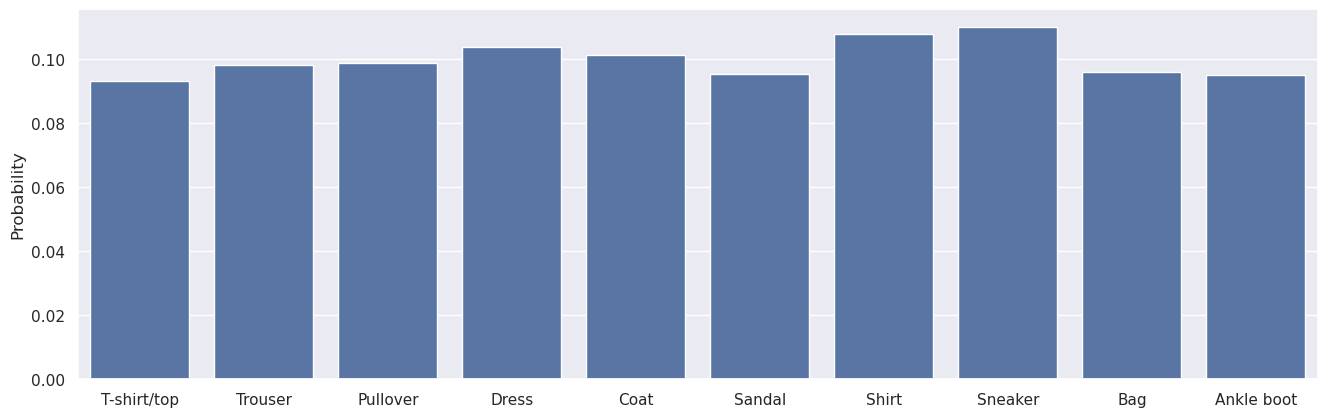

In [40]:
import seaborn as sns; sns.set_theme()
sns.barplot(data)
plt.gcf().set_figwidth(16)
plt.gca().set_ylabel("Probability")
None

In [41]:
out = model(t).data.squeeze()

In [42]:
ps = torch.nn.functional.softmax(out, dim=-1)

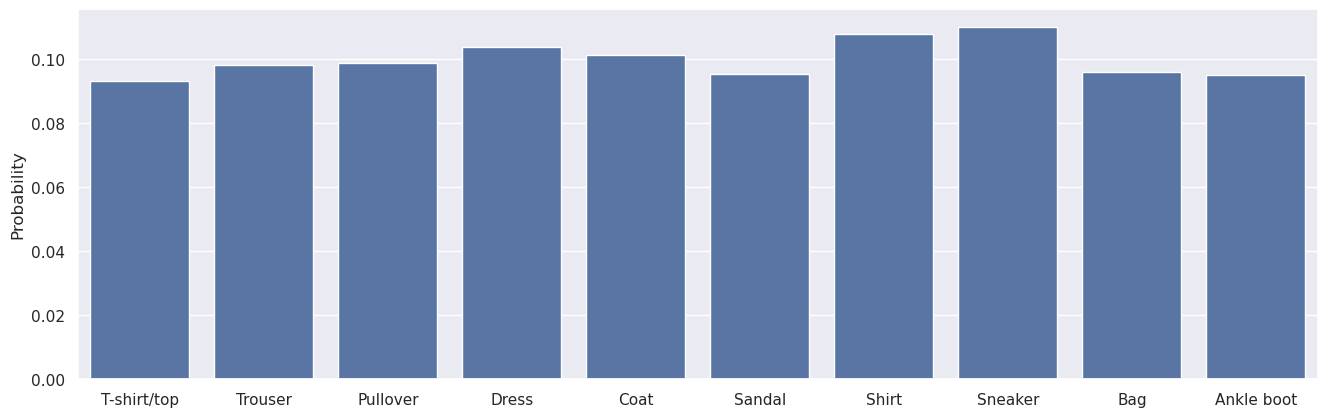

In [43]:
data = {training_data.classes[i]: p.item() for i, p in enumerate(ps)}
sns.barplot(data)
plt.gcf().set_figwidth(16)
plt.gca().set_ylabel("Probability")
None

## Training

In [44]:
batch_size = 64

# Create data loaders.
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [45]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [46]:
X, y = next(iter(train_dataloader)) # first dataloader input/ouput batch

In [47]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [48]:
def test(dataloader, model, loss_fn):
    """
    Returns:
      - score, the probability of a correct inference on the test test
    """
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.2f}%, Avg loss: {test_loss:>8f} \n")
    return correct

In [49]:
"""
test(test_dataloader, model, loss_fn)

epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    score = test(test_dataloader, model, loss_fn)
print("Done!")
"""

score = 0.0
new_score = test(test_dataloader, model, loss_fn)
epoch = 0
keep_learning = True
while keep_learning:
    epoch += 1
    score = new_score
    print(f"Epoch {epoch+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    new_score = test(test_dataloader, model, loss_fn)
    keep_learning = new_score > score

print("Done!")


Test Error: 
 Accuracy: 14.51%, Avg loss: 2.310602 

Epoch 2
-------------------------------
loss: 2.310137  [   64/60000]
loss: 2.294609  [ 6464/60000]
loss: 2.279354  [12864/60000]
loss: 2.274380  [19264/60000]
loss: 2.260585  [25664/60000]
loss: 2.228489  [32064/60000]
loss: 2.230296  [38464/60000]
loss: 2.202374  [44864/60000]
loss: 2.205322  [51264/60000]
loss: 2.164865  [57664/60000]
Test Error: 
 Accuracy: 41.07%, Avg loss: 2.166812 

Epoch 3
-------------------------------
loss: 2.176788  [   64/60000]
loss: 2.164339  [ 6464/60000]
loss: 2.114079  [12864/60000]
loss: 2.131708  [19264/60000]
loss: 2.082350  [25664/60000]
loss: 2.020625  [32064/60000]
loss: 2.043784  [38464/60000]
loss: 1.974149  [44864/60000]
loss: 1.988587  [51264/60000]
loss: 1.903135  [57664/60000]
Test Error: 
 Accuracy: 59.08%, Avg loss: 1.912942 

Epoch 4
-------------------------------
loss: 1.944222  [   64/60000]
loss: 1.907190  [ 6464/60000]
loss: 1.806999  [12864/60000]
loss: 1.844366  [19264/60000]
l

In [55]:
torch.save(model.state_dict(), "models/reference-model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


## Use the Model

In [51]:
model = NeuralNetwork()
model.load_state_dict(torch.load("models/reference-model.pth"))

<All keys matched successfully>

In [52]:
classes = test_data.classes

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


Known category: Ankle boot
Predicted category: Ankle boot


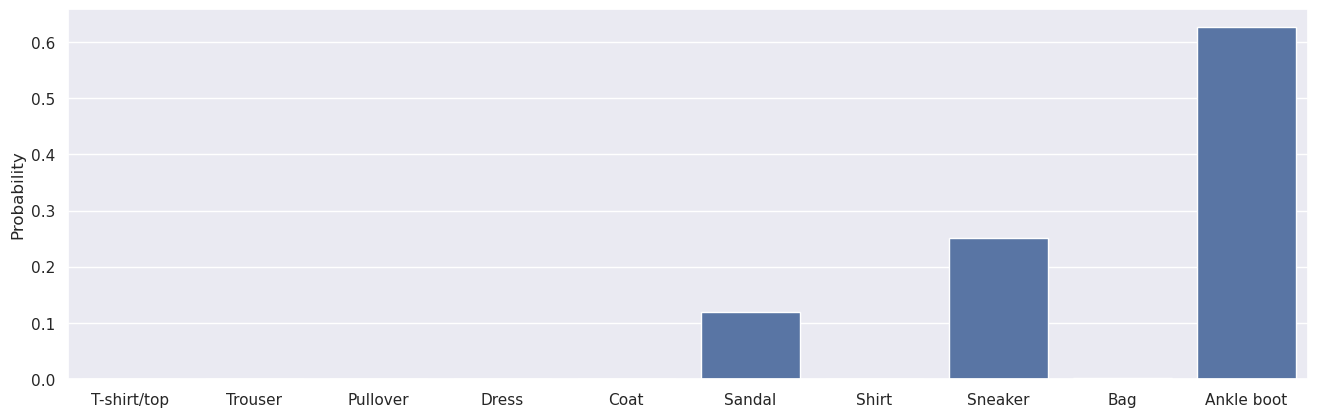

In [53]:
model.eval()
input, output = test_data[0][0], test_data[0][1]
print(f"Known category: {test_data.classes[output]}")
logits = model(input)
logits = logits.data.squeeze()
probas = torch.nn.functional.softmax(logits, dim=-1)
print(f"Predicted category: {test_data.classes[probas.argmax().item()]}")
data = {training_data.classes[i]: p.item() for i, p in enumerate(probas)}
sns.barplot(data)
plt.gcf().set_figwidth(16)
plt.gca().set_ylabel("Probability")
None